# Pentathlon-III: Next Product to Buy Models

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import metrics, preprocessing
from sklearn.inspection import permutation_importance
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

import warnings
warnings.filterwarnings("ignore")
# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data - this dataset must NOT be changed
pentathlon_nptb = pd.read_pickle("data/pentathlon_nptb.pkl")
pentathlon_nptb["buyer_yes"] = (pentathlon_nptb["buyer"] == "yes").astype(int)
# pentathlon_nptb.head()

In [3]:
pent = pentathlon_nptb

In [7]:
## Question answers

In [8]:
# pentathlon_nptb['gender'].get_dummies()
pent["gender"] = pd.get_dummies(pent["gender"])
pent[
    ["under_thirty", "thirty_to_fortyfour", "fortyfive_to_fiftynine", "sixty_and_above"]
] = pd.get_dummies(pent["age"])

In [9]:
rvar = "buyer_yes"
std_var = [
    "education",
    "children",
    "income",
    "freq_endurance",
    "freq_strength",
    "freq_water",
    "freq_team",
    "freq_backcountry",
    "freq_winter",
    "freq_racquet",
]
idvar = "custid"
lev = 1

In [10]:
pd.set_option("display.max_columns", None)

# standardization-- when standardizing, do we look at training == 1 or do we look at representative == 1?
X_colnames = pent.loc[
    [0],
    [
        "education",
        "children",
        "income",
        "freq_endurance",
        "freq_strength",
        "freq_water",
        "freq_team",
        "freq_backcountry",
        "freq_winter",
        "freq_racquet",
    ],
].columns
scaler = preprocessing.StandardScaler()
sf = scaler.fit(pent.query("training == 1")[X_colnames])
pent_std = pent.copy()

# new standardized cols
pent_std[std_var] = sf.transform(pent[X_colnames])

In [11]:
# storing results for evaluation of different models
train = pent.loc[pent["training"] == 1]
test = pent.loc[pent["training"] == 0]

eval_dat = pd.concat([train, test], axis=0)
eval_dat = eval_dat[[idvar, rvar, "training"]]

# Logistic Regression

The following blocks can be un-commented to try to fine tune the model, and to check.

In [12]:
# #buyer vs. age
# ct = rsm.cross_tabs(
#     pent_std.query("representative == 1"), "buyer", "age"
# )  # there is association b/w age and buying
# ct.summary(output="perc_col")

In [13]:
# #buyer vs. gender
# ct = rsm.cross_tabs(
#     pent_std.query("representative == 1"), "buyer", "gender"
# )  # significant
# ct.summary(output="perc_col")

In [14]:
# # buyer vs. message
# ct = rsm.cross_tabs(
#     pent_std.query("representative == 1"), "buyer", "message"
# )  # no significance
# ct.summary(output="perc_col")

In [15]:
# reg = smf.ols(
#     formula="total_os ~ buyer_yes", data=pent_std.query("representative == 1")
# ).fit()
# rsm.coef_ci(reg)

In [16]:
# reg = smf.ols(
#     formula="income ~ buyer_yes", data=pent_std.query("representative == 1")
# ).fit()
# rsm.coef_ci(reg)

In [17]:
# reg = smf.ols(
#     formula="education ~ buyer_yes", data=pent_std.query("representative == 1")
# ).fit()
# rsm.coef_ci(reg)

In [18]:
# reg = smf.ols(
#     formula="children ~ buyer_yes", data=pent_std.query("representative == 1")
# ).fit()
# rsm.coef_ci(reg)

In [19]:
# rsm.correlation(
#     pent_std.query("representative == 1")[
#         ["total_os", "income", "education", "children"]
#     ]
# ).summary()

In [20]:
# adding cweights
pent_std["cweight"] = rsm.ifelse(pent_std.buyer == "yes", 1, 99)

In [21]:
# base regression model-- that does not have interactions and is not flexible to allow for customizations
lr = smf.glm(
    formula="buyer_yes ~ message + income + education + children + gender + under_thirty + thirty_to_fortyfour + \
    fortyfive_to_fiftynine + sixty_and_above +\
    freq_strength + freq_water + freq_team + freq_backcountry + freq_winter + freq_racquet + freq_endurance +\
    message:gender",
    family=Binomial(link=logit()),
    freq_weights=np.asarray(pent_std.query("training == 1")["cweight"]),
    data=pent_std.query("training == 1"),
).fit()
# (rsm.or_ci(lr))

In [22]:
# # ONLY RUN IF NEEDED
# base_df = pent_std

# base_df["p_strength"] = lr.predict(base_df.assign(message="strength"))
# base_df["p_water"] = lr.predict(base_df.assign(message="water"))
# base_df["p_team"] = lr.predict(base_df.assign(message="team"))
# base_df["p_backcountry"] = lr.predict(base_df.assign(message="backcountry"))
# base_df["p_winter"] = lr.predict(base_df.assign(message="winter"))
# base_df["p_racquet"] = lr.predict(base_df.assign(message="racquet"))
# base_df["p_endurance"] = lr.predict(base_df.assign(message="endurance"))

In [23]:
# # ONLY RUN IF NEEDED
# base_df["to_offer"] = (
#     base_df[["p_strength", "p_water", "p_team", 'p_backcountry', 'p_winter', 'p_racquet', 'p_endurance']]
#     .idxmax(axis=1)
#     .str.replace("p_strength", "strength")
#     .replace("p_water", "water")
#     .replace("p_team", "team")
#     .replace("p_backcountry", "backcountry")
#     .replace("p_winter", "winter")
#     .replace("p_racquet", "racquet")
#     .replace("p_endurance", "endurance")
# )

In [24]:
# customized model-- which can be improved down the lane
lr_2 = smf.glm(
    formula="buyer_yes ~ message + education + children + gender + age+\
    freq_strength + freq_water + freq_team + freq_backcountry + freq_winter + freq_racquet + freq_endurance +\
    message:gender + message:income + message:education + message:children + message:age+\
    message:freq_strength + message:freq_water + message:freq_team + message:freq_backcountry + message:freq_winter +\
    message:freq_racquet + message:freq_endurance",
    family=Binomial(link=logit()),
    data=pent_std.query("training == 1"),
    freq_weights=np.asarray(pent_std.query("training == 1")["cweight"]),
).fit(cov_type="HC1")
# (rsm.or_ci(lr))

In [25]:
# #To check that everthing is significant
# lr_2.wald_test_terms().table.round(3)

In [26]:
# run predictions for each customer given they are targeted with each of the 7 messages
pent_std["p_strength_i"] = lr_2.predict(pent_std.assign(message="strength"))
pent_std["p_water_i"] = lr_2.predict(pent_std.assign(message="water"))
pent_std["p_team_i"] = lr_2.predict(pent_std.assign(message="team"))
pent_std["p_backcountry_i"] = lr_2.predict(pent_std.assign(message="backcountry"))
pent_std["p_winter_i"] = lr_2.predict(pent_std.assign(message="winter"))
pent_std["p_racquet_i"] = lr_2.predict(pent_std.assign(message="racquet"))
pent_std["p_endurance_i"] = lr_2.predict(pent_std.assign(message="endurance"))

In [27]:
preds = ['p_strength_i', 'p_water_i', 'p_team_i', 'p_backcountry_i', 'p_winter_i', 'p_racquet_i', 'p_endurance_i']

In [28]:
y_train = pent_std.query("training == 1")['buyer_yes']
y_test = pent_std.query("training == 0")['buyer_yes']


In [29]:
# get the message that will result in the highest profit for each customer
pent_std["to_offer_i"] = (
    pent_std[
        [
            "p_strength_i",
            "p_water_i",
            "p_team_i",
            "p_backcountry_i",
            "p_winter_i",
            "p_racquet_i",
            "p_endurance_i",
        ]
    ]
    .idxmax(axis=1)
    .str.replace("p_strength_i", "strength")
    .replace("p_water_i", "water")
    .replace("p_team_i", "team")
    .replace("p_backcountry_i", "backcountry")
    .replace("p_winter_i", "winter")
    .replace("p_racquet_i", "racquet")
    .replace("p_endurance_i", "endurance")
)

In [30]:
# using the predctions for each of the messages, get the prediction of the value
pent_std["p_target_i"] = pent_std[
    [
        "p_strength_i",
        "p_water_i",
        "p_team_i",
        "p_backcountry_i",
        "p_winter_i",
        "p_racquet_i",
        "p_endurance_i",
    ]
].max(axis=1)

In [31]:
pred_2_tr = pent_std.query("training == 1")['p_target_i']
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_2_tr)

pred_2_test = pent_std.query("training == 0")['p_target_i']
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, pred_2_test)

print(f"AUC training data for intial model: {(metrics.auc(fpr, tpr) * 100).round(2)}%")
print(f"AUC testing data for intial model: {(metrics.auc(fpr_t, tpr_t) * 100).round(2)}%\n")

AUC training data for intial model: 88.16%
AUC testing data for intial model: 88.17%



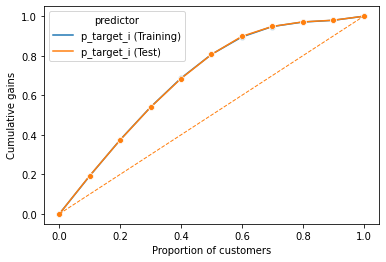

In [32]:

# fig1 = rsm.gains_plot(
#         {
#             "Training": pent_std.query("training == 1"),
#             "Test": pent_std.query("training == 0"),
#         },
#         rvar="buyer_yes",
#         pred='p_target_i',
#         lev=1,
#         qnt=10,
#     )

In [33]:
# #to check the number of customers to message per message type
# pd.crosstab(index=pent_std["to_offer_i"], columns="count").apply(rsm.format_nr)

In [34]:
# for the entire 200K customers, get the percentage of cusomers for whom each message type will lead to the highest probability of purchase
full_perc = pent_std[pent_std['representative'] == 0][
    [
        "p_strength_i",
        "p_water_i",
        "p_team_i",
        "p_backcountry_i",
        "p_winter_i",
        "p_racquet_i",
        "p_endurance_i",
        "p_target_i",
    ]
].agg("mean").sort_values(ascending=True).apply(rsm.format_nr, perc=True)

### Q1: determine the message (i.e., endurance, strength, water, team, backcountry, winter, or racquet) predicted to lead to the highest probability of purchase. Describe your approach.

In [35]:
# df to deal just with the representative data for questions 1-8
reps = pent_std[pent_std["representative"] == 1].reset_index(drop=True)

In [36]:
#for each customer, the message that will lead to the highest probability of purchase
q1 = reps[["custid", "to_offer_i"]]

### Q2: For each message, report the percentage of customers for whom that message maximizes their probability of purchase.

In [37]:
q2_redone = reps['to_offer_i'].value_counts(normalize = True)* 100

In [38]:
q2 = pd.DataFrame(q2_redone)
q2.columns = ['customers (%)']
#q2

### Q3: For each customer, determine the message (i.e., endurance, strength, water, team, backcountry, winter, or racquet) predicted to lead to the highest expected profit (COGS is 60%)

In [40]:
#use a linear regression model to predict the order size for each of the messages for each customer
reg_ep = smf.ols(
    formula="total_os ~ message:gender + message:income + message:education + message:children + message:age+\
    message:freq_strength + message:freq_water + message:freq_team + message:freq_backcountry + message:freq_winter +\
    message:freq_racquet + message:freq_endurance",
    data=pent_std[(pent_std["training"] == 1) & (pent_std["buyer"] == "yes")],
).fit()

In [43]:
# run prediction for each customer to find the order size for each message type
reps["p_strength_os"] = reg_ep.predict(reps.assign(message="strength"))
reps["p_water_os"] = reg_ep.predict(reps.assign(message="water"))
reps["p_team_os"] = reg_ep.predict(reps.assign(message="team"))
reps["p_backcountry_os"] = reg_ep.predict(reps.assign(message="backcountry"))
reps["p_winter_os"] = reg_ep.predict(reps.assign(message="winter"))
reps["p_racquet_os"] = reg_ep.predict(reps.assign(message="racquet"))
reps["p_endurance_os"] = reg_ep.predict(reps.assign(message="endurance"))

In [50]:
# for each message, calculate the expected profit (by using the predicted probability of purchase and the predicted order size)
reps["ep_strength"] = reps["p_strength_os"] * reps["p_strength_i"] * 0.4
reps["ep_water"] = reps["p_water_os"] * reps["p_water_i"] * 0.4
reps["ep_team"] = reps["p_team_os"] * reps["p_team_i"] * 0.4
reps["ep_backcountry"] = reps["p_backcountry_os"] * reps["p_backcountry_i"] * 0.4
reps["ep_winter"] = reps["p_winter_os"] * reps["p_winter_i"] * 0.4
reps["ep_racquet"] = reps["p_racquet_os"] * reps["p_racquet_i"] * 0.4
reps["ep_endurance"] = reps["p_endurance_os"] * reps["p_endurance_i"] * 0.4

In [51]:
# message to offer to maximize expected profit
reps["to_offer_ep"] = (
    reps[
        [
            "ep_strength",
            "ep_water",
            "ep_team",
            "ep_backcountry",
            "ep_winter",
            "ep_racquet",
            "ep_endurance",
        ]
    ]
    .idxmax(axis=1)
    .str.replace("ep_strength", "strength")
    .replace("ep_water", "water")
    .replace("ep_team", "team")
    .replace("ep_backcountry", "backcountry")
    .replace("ep_winter", "winter")
    .replace("ep_racquet", "racquet")
    .replace("ep_endurance", "endurance")
)

In [52]:
# get the targeted expected profit 
reps["ep_target"] = reps[
    [
        "ep_strength",
        "ep_water",
        "ep_team",
        "ep_backcountry",
        "ep_winter",
        "ep_racquet",
        "ep_endurance",
    ]
].max(axis=1)

In [54]:
q3 = reps[["custid", "to_offer_ep"]]  # q3

### 4. Report for each message, i.e., endurance, racket, etc., the percentage of customers for whom that message maximizes their expected profit.

In [56]:
q4 = (reps['to_offer_ep'].value_counts(normalize = True) * 100)
q4 = pd.DataFrame(q4)
q4.columns = ['customers (%)']

### 5. What expected profit can we obtain, on average, per e-mailed customer if we customize the message to each customer?

In [88]:
q5 = (
    reps[["ep_target"]]
    .agg("mean")
    .sort_values(ascending=False)
    .apply(rsm.format_nr, dec = 3, sym="€")
)

### 6. What is the expected profit per e-mailed customer if every customer receives the same message? Answer this question for each of the seven possible messages (i.e., endurance, strength, water, team, backcountry, winter, or racquet).

In [58]:
q6 = (
    reps[
        [
            "ep_strength",
            "ep_water",
            "ep_team",
            "ep_backcountry",
            "ep_winter",
            "ep_racquet",
            "ep_endurance",
        ]
    ]
    .agg("mean")
    .sort_values(ascending=False)
    .apply(rsm.format_nr, sym="€")
)

In [59]:
q6 = pd.DataFrame(q6)
q6.columns = ['Avg. EP']

### 7. What is the expected profit per e-mailed customer if every customer is assigned randomly to one of the seven messages?

In [61]:
np.random.seed(1234)
categ = ['team', 'racquet', 'backcountry', 'water', 'winter', 'strength', 'endurance']
reps['to_offer_rnd'] = np.random.choice(categ, size = reps.shape[0])
#reps['offer_rnd'].value_counts()

In [63]:
#for each random message assignment, get the probability and assign it to a column
def rnd_target_col():
    cols = []
    for x in range(len(reps)):
        col = "ep_" + str(reps["to_offer_rnd"][x])
        vals = reps[col][x]
        cols.append(vals)
    return cols


reps['rnd_target'] = rnd_target_col()

In [89]:
# repeat ep_{message}_rnd [result in 7 cols] -> to_offer_ep_rnd -> ep_target_rnd -> Q5
# get the targeted expected profit 
q7 = (
    reps[["rnd_target"]]
    .agg("mean")
    .sort_values(ascending=False)
    .apply(rsm.format_nr, dec = 3, sym="€")
)


### 8. For the typical promotional e-mail blast to 5,000,000 customers, what improvement (in percent and in total Euros) could Pentathlon achieve by customizing the message to each customer rather than assigning customers a message randomly?

In [100]:
# difference between Q7 and Q5 -> scale to 5M
q8_profit = round(np.abs(float(q7['rnd_target'].replace('€', '')) - float(q5['ep_target'].replace('€', ''))), 3)
#print(f"Expected profit improvement from offering customization: €{q8_profit.round(3):,}")

Expected profit improvement from offering customization: €0.095


In [105]:
ep_target = (reps['ep_target'].agg('mean') * 5000000)
ep_rnd = (reps['rnd_target'].agg('mean') * 5000000)

q8_profit_sc = ep_target - ep_rnd
#print(f"Expected profit difference (in Euros) from offering customization scaled to 5M customers: €{q8_profit_sc.round(3):,}")

Expected profit difference (in Euros) from offering customization scaled to 5M customers: €471,249.48


In [69]:
q8_perc = (q8_profit/float(q7['rnd_target'].replace('€', '')))*100
#print(f"Expected profit difference (as a percentage) from offering customization scaled to 5M customers: {q8_perc.round(2):,}%") 

In [111]:
# # compare initial message column and to_offer_i content?
# # groupby message = 7 cols -> compare with to_offer_i counts that match the message/total of groupby * 100
# a = reps.groupby(["message", "to_offer_rnd"])[["to_offer_i"]].agg("count").reset_index()
# b = a.groupby("message")[["to_offer_i"]].agg("sum").reset_index()
# c = a[a["message"] == a["to_offer_rnd"]].drop(columns=["to_offer_rnd"])
# max_prof_rnd = c.merge(b, left_on="message", right_on="message", how="inner")
# max_prof_rnd = max_prof_rnd.assign(
#     perc_cust_rnd=round(((max_prof_rnd["to_offer_i_x"] / max_prof_rnd["to_offer_i_y"])*100), 2)
# )[["message", "perc_cust_rnd"]]
# q8_perc = max_prof_rnd

# q8_perc

In [72]:
#comp = q4.merge(q8_perc, on = 'message', how = 'left')
#comp